# Power Spectra LFP Analysis"

Brief 1-2 sentence description of notebook.

In [1]:
import os
import glob
from collections import defaultdict
import re

In [2]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy import stats
import itertools

import spikeinterface.extractors as se
import spikeinterface.preprocessing as sp
from spectral_connectivity import Multitaper, Connectivity

## Inputs & Data

Explanation of each input and where it comes from.

In [3]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case

In [4]:
BBOX_TO_ANCHOR=(1.5, 0.9)
LOC='upper right'

In [5]:
# variables for LFP extraction
FREQ_MIN=0.5
FREQ_MAX=300
FREQ=60
RESAMPLE_RATE=1000
TRIAL_DURATION=10

In [6]:
INPUT_VARIABLE = 1

TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 3
TIME_WINDOW_STEP = 1.5 

TRIAL_TIME_STAMP_DURATION = 1000*10

In [7]:
BIN_TO_COLOR = {0: {"baseline": "lightblue", "trial": "blue"}, 1: {"baseline": "lightgreen", "trial": "green"}, 2: {"baseline": "lightcoral", "trial": "red"}}
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}
BIN_TO_VELOCITY = {0: "0 to 2.5cm/s", 1: "2.5 to 5cm/s", 2: "5cm/s to 10cm/s"}

In [8]:
BIN_TO_COLOR = {0: {"baseline": "lightblue", "trial": "blue"}, 1: {"baseline": "lightgreen", "trial": "green"}, 2: {"baseline": "lightcoral", "trial": "red"}}
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}
BIN_TO_VELOCITY = {0: "0 to 5cm/s", 1: "5cm/s to 10cm/s", 2: "10cm/s+"}

In [9]:
NUM_LINES = 3

In [10]:
# Generate colors from the "Blues" colormap
LOSING_COLORS = cm.Oranges(np.linspace(0.5, 1, NUM_LINES))
# Generate colors from the "Blues" colormap
WINNING_COLORS = cm.Blues(np.linspace(0.5, 1, NUM_LINES))
# Generate colors from the "Blues" colormap
REWARDED_COLORS = cm.Greens(np.linspace(0.5, 1, NUM_LINES))
# Generate colors from the "Blues" colormap
OMISSION_COLORS = cm.Reds(np.linspace(0.5, 1, NUM_LINES))

In [11]:
BASELINE_OUTCOME_TO_COLOR = {'lose': "orange",
 'lose_baseline': LOSING_COLORS[0],
 'omission': "red",
 'omission_baseline': "hotpink",
 'rewarded': "green",
 'rewarded_baseline': REWARDED_COLORS[0],
 'win': "blue",
 'win_baseline': WINNING_COLORS[0]}

In [12]:
COMPETITIVE_OUTCOME_TO_COLOR = {'lose_comp': "orange", 
'lose_non_comp': "yellow",
'omission': "red",
'rewarded': "green",
'win_comp': "blue", 
'win_non_comp': WINNING_COLORS[0]}

In [13]:
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}

In [14]:
ALL_TRIALS_DF = pd.read_pickle("./proc/rce_1_sec_interval_lfp_power_spectra_and_velocity.pkl")

OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs


In [15]:
ALL_TRIALS_DF.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,...,eib_LH,eib_MD,brain_region,channel,chunked_current_trace,len_chunked_current_trace,frequencies,power,theta_power,averaged_theta_power
0,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,18,19,spike_interface_mPFC,5,"[1.2846744, 1.113752, 0.7553665, 0.60466075, 0...",1000,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.02309027537108904, 0.03376274381096272, 0.0...","[0.04938388096425996, 0.04342801146774383, 0.0...",0.030023
0,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,18,19,spike_interface_mPFC,5,"[1.4776512, 1.4813269, 1.3287834, 1.1174278, 1...",1000,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.02037680255662344, 0.02703298332514505, 0.0...","[0.051952263343390384, 0.040229612907454346, 0...",0.024354
0,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,18,19,spike_interface_mPFC,5,"[-0.88034195, -0.4502793, 0.033081744, -0.1249...",1000,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.06475578281033083, 0.04809674891904778, 0.0...","[0.03068296312066393, 0.03252587186937053, 0.0...",0.020135
0,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,18,19,spike_interface_mPFC,5,"[0.093731605, -0.05513624, -0.24443734, -0.317...",1000,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.024690271716308453, 0.024697344579884397, 0...","[0.0296455331238504, 0.02475973621287092, 0.03...",0.026704
0,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,18,19,spike_interface_mPFC,5,"[-0.40249455, -0.51092917, -0.46314442, -0.382...",1000,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.03691878756910202, 0.04017695307697495, 0.0...","[0.04759429806596745, 0.05791219782040157, 0.0...",0.032783


## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Functions

- Ideally functions are defined here first and then data is processed using the functions
    - function names are short and in snake case all lowercase
    - a function name should be unique but does not have to describe the function
    - doc strings describe functions not function names

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [16]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

## Plotting all the lower velocities together

- binned_current_thorax_velocity:
    - 0: 0 to 5cm/s
    - 1: 5 to 10cm/s
    - 2: 10cm/s+

In [17]:
ALL_TRIALS_DF["binned_current_thorax_velocity"].unique()

array([0, 1, 2], dtype=object)

- Filtering for velocity

In [18]:
speed_filtered_all_trials_df = ALL_TRIALS_DF[ALL_TRIALS_DF["binned_current_thorax_velocity"] == 0]

In [19]:
speed_filtered_all_trials_df.shape

(11965, 75)

In [20]:
all_frequencies = speed_filtered_all_trials_df["frequencies"].iloc[0]

In [21]:
all_frequencies

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [22]:
speed_filtered_all_trials_df["power"].iloc[0].shape

(500,)

- Filter by frequnecy band

In [23]:
speed_filtered_all_trials_df["theta_power_for_all_segments"] = speed_filtered_all_trials_df["power"].apply(lambda x: x[4:13])

/tmp/ipykernel_1452564/2232891006.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speed_filtered_all_trials_df["theta_power_for_all_segments"] = speed_filtered_all_trials_df["power"].apply(lambda x: x[4:13])


In [24]:
speed_filtered_all_trials_df["theta_power_for_all_segments"].iloc[0]

array([0.04938388, 0.04342801, 0.041652  , 0.03913568, 0.04028102,
       0.03282091, 0.00594168, 0.007443  , 0.01011821])

- Getting the mean power for all frequency bands for one time segment

In [25]:
speed_filtered_all_trials_df["mean_theta_power"] = speed_filtered_all_trials_df["theta_power_for_all_segments"].apply(lambda x: np.mean(x))

/tmp/ipykernel_1452564/202648374.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speed_filtered_all_trials_df["mean_theta_power"] = speed_filtered_all_trials_df["theta_power_for_all_segments"].apply(lambda x: np.mean(x))


In [26]:
speed_filtered_all_trials_df["mean_theta_power"].iloc[0]

0.03002271026529775

- Getting the average of all the mean powers for each group

In [27]:
mean_power_df = pd.DataFrame(speed_filtered_all_trials_df.groupby(['brain_region', 'trial_outcome', 'trial_or_baseline'])["mean_theta_power"].mean()).reset_index()

In [28]:
sem_power_df = pd.DataFrame(speed_filtered_all_trials_df.groupby(['brain_region', 'trial_outcome', 'trial_or_baseline'])["mean_theta_power"].sem()).reset_index()

In [29]:
mean_power_df.head(n=20)

,brain_region,trial_outcome,trial_or_baseline,mean_theta_power
0,spike_interface_BLA,lose,baseline,0.028434
1,spike_interface_BLA,lose,trial,0.032606
2,spike_interface_BLA,omission,baseline,0.018592
3,spike_interface_BLA,omission,trial,0.018948
4,spike_interface_BLA,rewarded,baseline,0.021026
5,spike_interface_BLA,rewarded,trial,0.019681
6,spike_interface_BLA,win,baseline,0.022543
7,spike_interface_BLA,win,trial,0.025446
8,spike_interface_LH,lose,baseline,0.032809
9,spike_interface_LH,lose,trial,0.040264


In [30]:
sem_power_df.head(n=20)

,brain_region,trial_outcome,trial_or_baseline,mean_theta_power
0,spike_interface_BLA,lose,baseline,0.000947
1,spike_interface_BLA,lose,trial,0.003911
2,spike_interface_BLA,omission,baseline,0.000944
3,spike_interface_BLA,omission,trial,0.000914
4,spike_interface_BLA,rewarded,baseline,0.000541
5,spike_interface_BLA,rewarded,trial,0.000404
6,spike_interface_BLA,win,baseline,0.000533
7,spike_interface_BLA,win,trial,0.002668
8,spike_interface_LH,lose,baseline,0.001991
9,spike_interface_LH,lose,trial,0.006717


- Plot the mean power

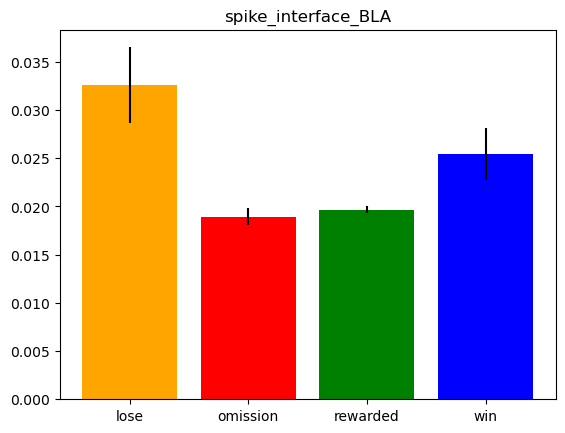

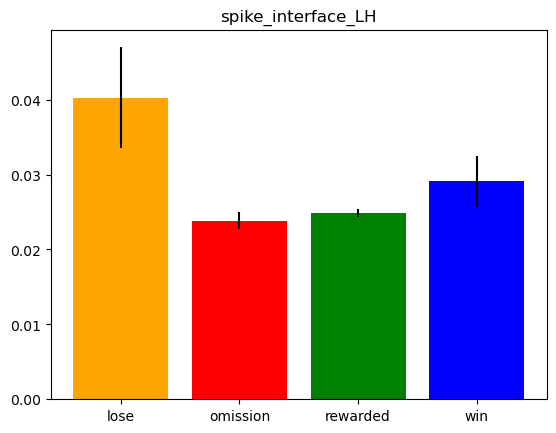

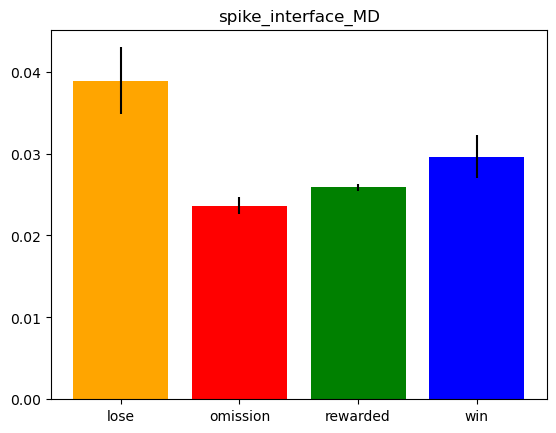

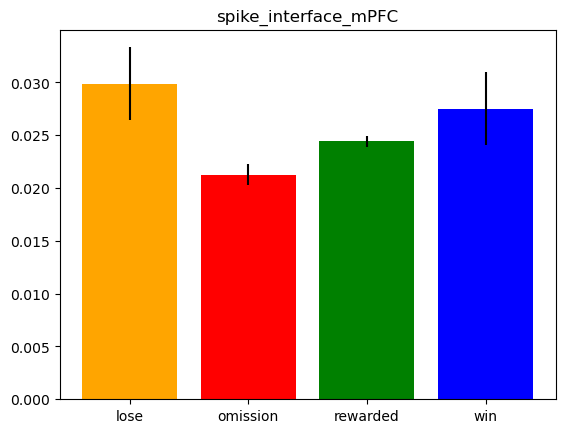

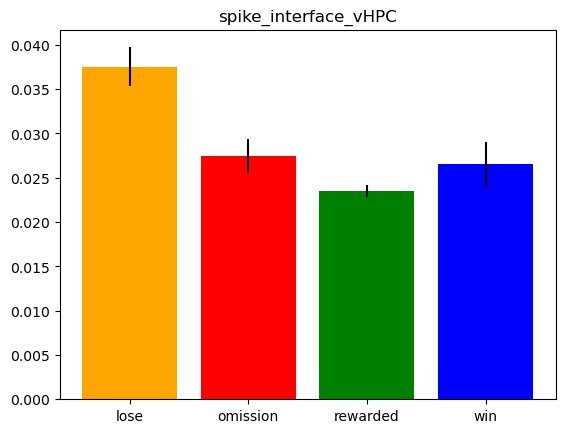

In [31]:
for region in mean_power_df["brain_region"].unique():
    fig, ax = plt.subplots()
    mean_region_df = mean_power_df[(mean_power_df["brain_region"] == region) & (mean_power_df["trial_or_baseline"] == "trial")]
    sem_region_df = sem_power_df[(sem_power_df["brain_region"] == region) & (sem_power_df["trial_or_baseline"] == "trial")]

        
    # Create a list of colors based on the categories
    colors = [BASELINE_OUTCOME_TO_COLOR[cat] for cat in mean_region_df["trial_outcome"]]

    plt.title("{}".format(region))
    plt.xlabel("")
    plt.ylabel("")
    plt.bar(mean_region_df["trial_outcome"], mean_region_df["mean_theta_power"], yerr=sem_region_df["mean_theta_power"], color=colors)
    